In [1]:
from argparse import Namespace
from tqdm import tqdm
from typing import List, Sequence, Tuple

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import optax

from jax_learning.losses.supervised_loss import squared_loss
from jax_learning.models.embeddings import PositionalEmbedding1D
from jax_learning.models.layers import MLP, Conv2D, Conv2DTranspose

In [2]:
seed = 0
np.random.seed(seed)

# Download MNIST
Reference: https://github.com/hsjeong5/MNIST-for-Numpy/blob/master/mnist.py

In [3]:
import gzip
import numpy as np
import os
import pickle

from urllib import request

filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

if not os.path.isfile("mnist.pkl"):
    init()
    
print("loading MNIST dataset")
(train_x, train_y, test_x, test_y) = load()
train_x = train_x.astype(float) / 255
test_x = test_x.astype(float) / 255
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

data_mean = np.mean(train_x, axis=0)
data_std = np.std(train_x, axis=0)
data_std[data_std != data_std] = 1
data_std[data_std == 0.] = 1
print(np.all(np.isfinite(data_std)))
print(np.all(np.isfinite(data_mean)))
print(np.all(np.isfinite(train_x)))
train_x = (train_x - data_mean) / data_std
print(np.all(np.isfinite(train_x)))

train_x = train_x[train_y == 1]
train_y = train_y[train_y == 1]
print(train_x.shape, train_y.shape)

loading MNIST dataset
(60000, 784) (60000,)
(10000, 784) (10000,)
True
True
True
True
(6742, 784) (6742,)


# Model Creation

In [4]:
@jax.jit
def identity(x):
    return x

def SAC_ENCODER(in_channels):
    return (
        [in_channels, 32, (3, 3), (2, 2), (0, 0), (1, 1), jax.nn.gelu, False],
        [32, 32, (3, 3), (1, 1), (0, 0), (1, 1), jax.nn.gelu, False],
        [32, 32, (3, 3), (1, 1), (0, 0), (1, 1), jax.nn.gelu, False],
        [32, 32, (3, 3), (1, 1), (0, 0), (1, 1), jax.nn.gelu, False],
    )

def SAC_DECODER(out_channels, in_dim):
    return (
        [32, 32, (3, 3), (1, 1), (0, 0), (1, 1), (0, 0), jax.nn.gelu, False],
        [32, 32, (3, 3), (1, 1), (0, 0), (1, 1), (0, 0), jax.nn.gelu, False],
        [32, 32, (3, 3), (1, 1), (0, 0), (1, 1), (0, 0), jax.nn.gelu, False],
        [32, out_channels, (3, 3), (2, 2), (0, 0), (1, 1), (in_dim[0] % 2 == 0, in_dim[1] % 2 == 0), identity, False],
    )

In [5]:
class Model(eqx.Module):
    gen_dim: Sequence[int] = eqx.static_field()

    def predict(
        self,
        x: np.ndarray,
        t: float,
    ) -> np.ndarray:
        raise NotImplementedError
            
    
class MLPModel(Model):
    model: eqx.Module
    emb: eqx.nn.Embedding = eqx.static_field()
    T: int = eqx.static_field()

    def __init__(
        self,
        gen_dim: Sequence[int],
        context_dim: Sequence[int],
        T: int,
        embedding_dim: int,
        hidden_dim: int,
        num_hidden: int,
        key: jrandom.PRNGKey,
    ):
        gen_dim = gen_dim
        self.emb = PositionalEmbedding1D(T, embedding_dim, key)
        self.model = MLP(gen_dim + context_dim + embedding_dim, gen_dim, hidden_dim, num_hidden, key, activation=jax.nn.gelu)
        self.T = T
        super().__init__(gen_dim)
        
    @jax.jit
    def predict(
        self,
        x: np.ndarray,
        c: np.ndarray,
        t: float,
    ) -> np.ndarray:
        t_emb = self.emb((t * self.T).astype(int))
        x_t = jnp.concatenate((x, c, t_emb))
        return self.model(x_t)


class CNNModel(Model):
    conv2d_layers: eqx.Module
    convtranspose2d_layers: eqx.Module
    mlp_layers: eqx.Module
    num_channels: int = eqx.static_field()
        
    def __init__(
        self,
        gen_dim: Sequence[int],
        context_dim: Sequence[int],
        num_channels: int,
        key: jrandom.PRNGKey,
    ):
        self.conv2d_layers = Conv2D(SAC_ENCODER(in_channels=num_channels),
                                    in_dim=gen_dim,
                                    key=jrandom.PRNGKey(seed))
        self.convtranspose2d_layers = Conv2DTranspose(SAC_DECODER(out_channels=num_channels,
                                                                  in_dim=gen_dim),
                                                      key=jrandom.PRNGKey(seed))
        conv_out_dim = int(np.product(self.conv2d_layers.out_dim))
        self.mlp_layers = MLP(conv_out_dim + context_dim + 1,
                              conv_out_dim, 256, 4, key=jrandom.PRNGKey(seed))
        self.num_channels = num_channels
        
        super().__init__(gen_dim)
        
    @jax.jit
    def predict(
        self,
        x: np.ndarray,
        c: np.ndarray,
        t: float,
    ) -> np.ndarray:
        z = self.conv2d_layers(x.reshape((self.num_channels, *self.gen_dim)))
        z_out = self.mlp_layers(jnp.concatenate((z.reshape(-1), c, jnp.array([t]))))
        x_t = self.convtranspose2d_layers(z_out.reshape(self.conv2d_layers.out_dim)).reshape(-1)
        return x_t

# DDPM

In [18]:
T = 40
lo = 0.0001
hi = 0.02
delta = (hi - lo) / (T - 1)
betas = jnp.array(np.arange(lo, hi + delta, delta))
alphas = 1 - betas
alpha_cum_prods = jnp.cumprod(alphas)

sqrt_alphas = jnp.sqrt(alphas)
sqrt_alpha_cumprods = jnp.sqrt(alpha_cum_prods)
sqrt_one_minus_alpha_cumprods = jnp.sqrt(1 - alpha_cum_prods)

# For sampling
variances = jnp.concatenate((np.zeros(0), betas[1:] * (1 - alpha_cum_prods[:-1]) / (1 - alpha_cum_prods[1:])))
inv_sqrt_alphas = 1 / sqrt_alphas
noise_coef = (1 - alphas) / sqrt_one_minus_alpha_cumprods

def add_noise(x_init: np.ndarray, noise: np.ndarray, t: np.int32):
    return sqrt_alpha_cumprods[t, None] * x_init + sqrt_one_minus_alpha_cumprods[t, None] * noise

In [7]:
@eqx.filter_grad(has_aux=True)
def compute_loss(model: Model, xs: np.ndarray, cs: np.ndarray, timesteps: np.ndarray, targs: np.ndarray):
    preds = jax.vmap(model.predict)(xs, cs, timesteps)
    loss = jnp.sum(jax.vmap(squared_loss)(preds, targs)) / len(xs)
    return loss, {"loss": loss}

In [8]:
def sample(model: Model, context: np.ndarray, gen_dim: Sequence[int], T: int):
    xs = [np.random.randn(*gen_dim)]
    for t in range(T - 1, -1 , -1):
        var_noise = np.random.randn(*gen_dim) * int(t > 0)
        xs.append(inv_sqrt_alphas[t] * (xs[-1] - noise_coef[t] * model.predict(xs[-1], context, t / T)) + variances[t] * var_noise)
    return xs

In [9]:
def train(
    train_x: np.ndarray,
    train_c: np.ndarray,
    model: Model,
    opt: optax.GradientTransformation,
    cfg: Namespace
) -> Tuple[Model, List]:
    """
    train_x: data to reconstruct
    train_c: data context
    model: the diffusion model
    opt: optimizer for changing the parameters of the model
    """
    opt_state = opt.init(model)
    losses = []
    
    for i in tqdm(range(cfg.num_iterations)):
        train_idxes = np.random.choice(len(train_x), size=cfg.batch_size)
        curr_c = train_c[train_idxes]
        curr_x = train_x[train_idxes]
        timesteps = np.random.randint(cfg.T, size=cfg.batch_size)
        
        noise = np.random.randn(*curr_x.shape)
        noisy_x = add_noise(curr_x, noise, timesteps)
        grads, info = compute_loss(model, noisy_x, curr_c[:, None], timesteps / cfg.T, noise)
        updates, opt_state = opt.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        if not np.isfinite(info["loss"]):
            assert 0
        losses.append(info["loss"])
        if i == 0 or (i + 1) % 500 == 0:
            preds = sample(model, curr_c[[0]], (cfg.gen_dim,), cfg.T)
            fig = plt.figure(figsize=(100, 10))
            ax = fig.add_subplot(1, T + 1, 1)
            ax.axis("off")
            for idx, pred in enumerate(preds[1:]):
                ax = fig.add_subplot(4, T // 4, 1 + idx)
                ax.axis("off")
                plt.imshow((pred * data_std + data_mean).reshape((28, 28)))

            fig.subplots_adjust(hspace=0, wspace=0)
            plt.show()
        
    return model, losses

  0%|                                                                                                | 0/100000 [00:00<?, ?it/s]

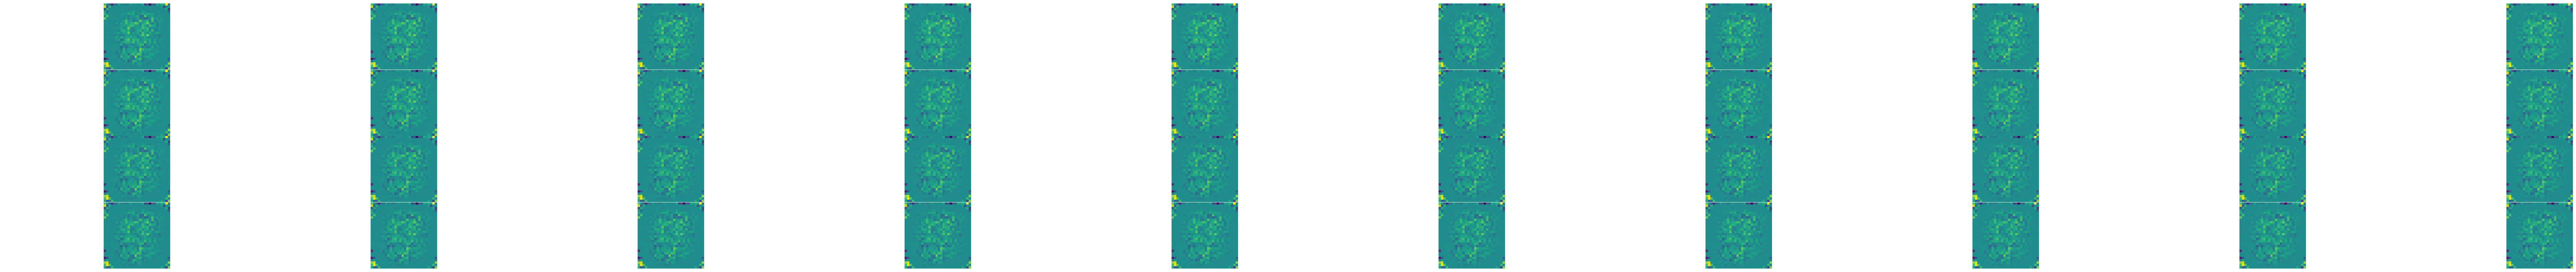

  0%|▍                                                                                     | 497/100000 [00:07<21:09, 78.36it/s]

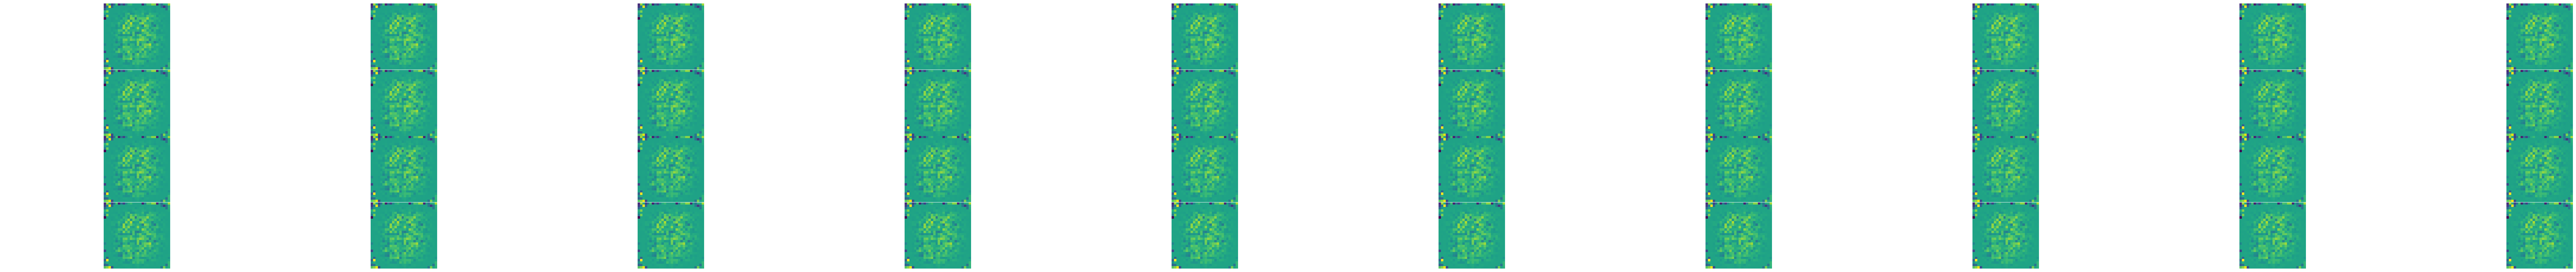

  1%|▊                                                                                     | 999/100000 [00:14<21:09, 77.99it/s]

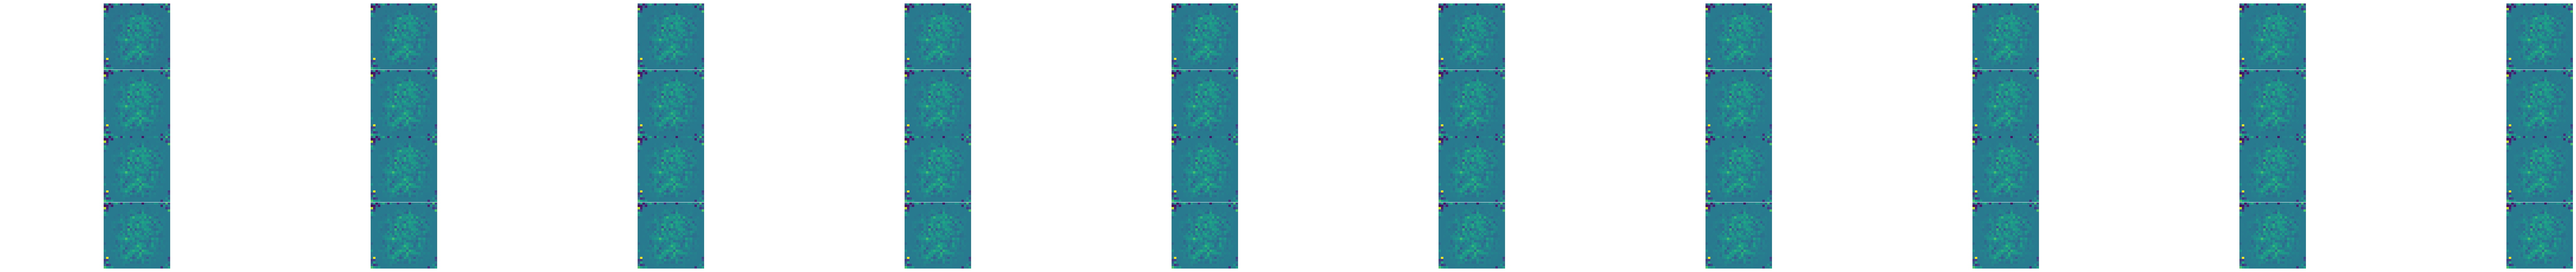

  1%|█▎                                                                                   | 1494/100000 [00:22<21:17, 77.08it/s]

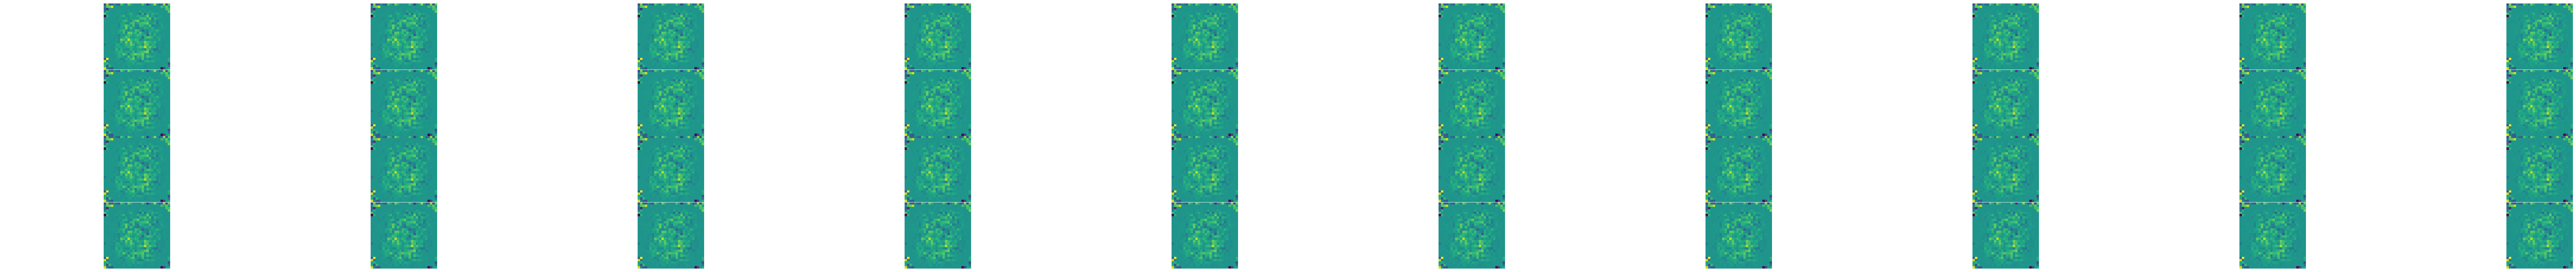

  2%|█▋                                                                                   | 1994/100000 [00:29<20:48, 78.52it/s]

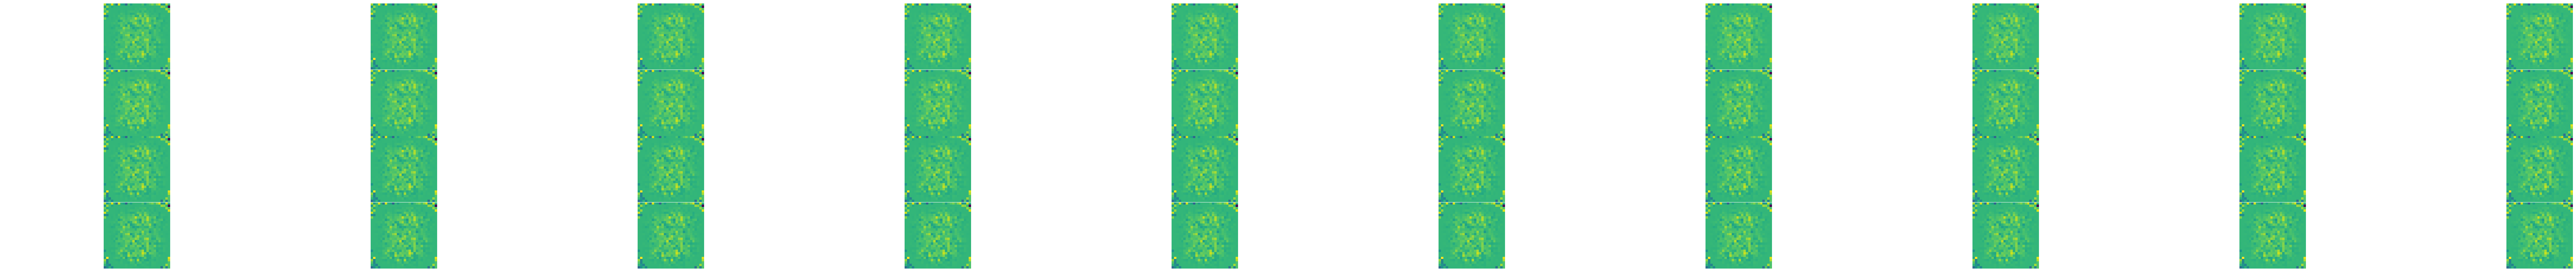

  2%|██                                                                                   | 2499/100000 [00:36<21:12, 76.65it/s]

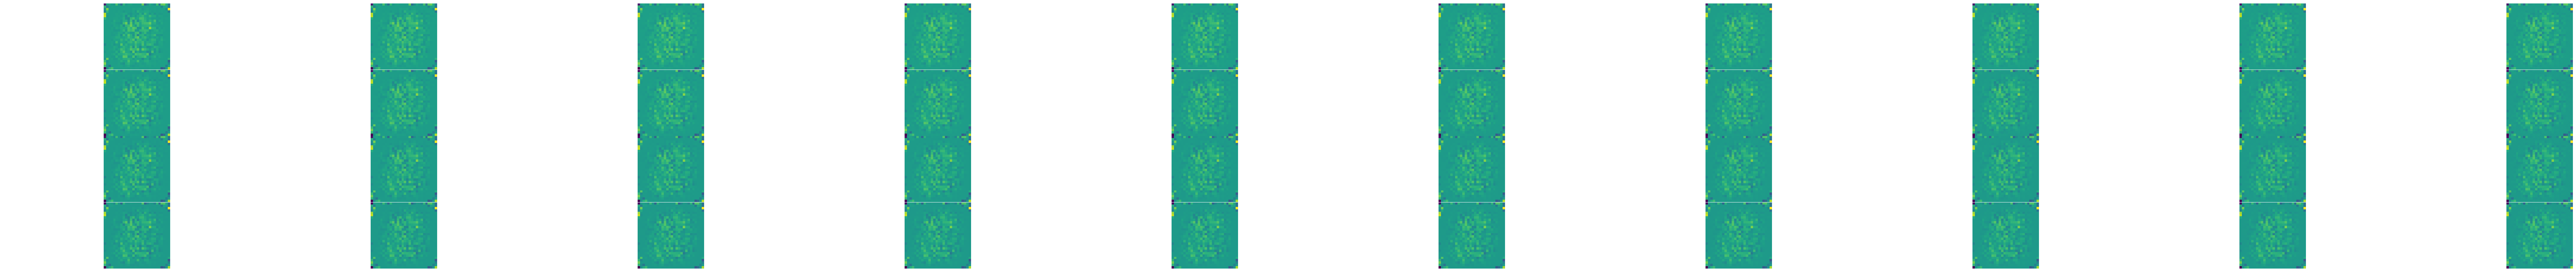

  3%|██▌                                                                                  | 2996/100000 [00:43<21:05, 76.68it/s]

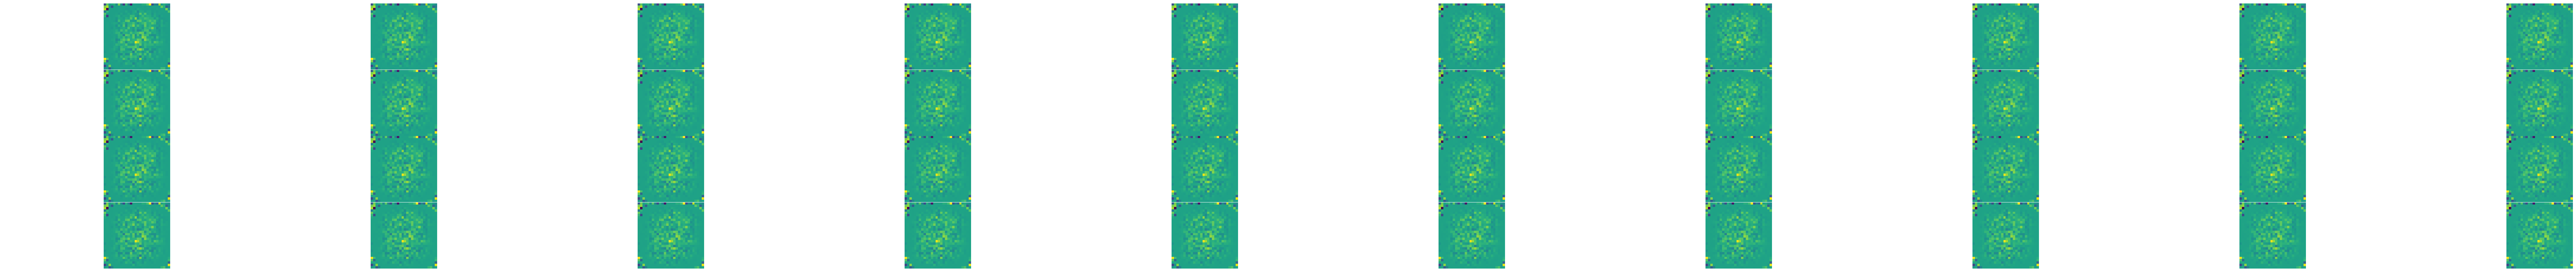

  3%|██▌                                                                                  | 3088/100000 [00:45<23:52, 67.67it/s]


KeyboardInterrupt: 

In [10]:
gen_dim = int(np.product(train_x.shape[1:]))
context_dim = 1
embedding_dim = 128
hidden_dim = 128
num_hidden = 4
key = jrandom.PRNGKey(seed)

model = MLPModel(gen_dim, context_dim, T, embedding_dim, hidden_dim, num_hidden, key)
# model = CNNModel((28, 28), 1, 1, key)

max_grad_norm = 1.
lr = 1e-4
opt_transforms = [optax.clip_by_global_norm(max_grad_norm), optax.scale_by_rms(), optax.scale(-lr)]
opt = optax.chain(*opt_transforms)

cfg_dict = {
    "num_iterations": 100000,
    "batch_size": 128,
    "T": T,
    "gen_dim": gen_dim,
}
cfg = Namespace(**cfg_dict)

trained_model, losses = train(train_x, train_y, model, opt, cfg)

In [ ]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)
ax.plot(np.arange(len(losses)), losses)
ax.set_xlabel("Number of updates")
ax.set_ylabel("Loss")
plt.show()

In [ ]:
preds = sample(trained_model, train_y[[0]], (gen_dim,), T)
baseline_preds = sample(model, train_y[[0]], (gen_dim,), T)

In [ ]:
fig = plt.figure(figsize=(50, 5))
ax = fig.add_subplot(3, T, 1)
ax.axis("off")
plt.imshow((train_x[0] * data_std + data_mean).reshape((28, 28)))

for idx, baseline_pred in enumerate(baseline_preds):
    ax = fig.add_subplot(3, T + 1, T + 1 + 1 + idx)
    ax.axis("off")
    plt.imshow((baseline_pred * data_std + data_mean).reshape((28, 28)))
    
for idx, pred in enumerate(preds):
    ax = fig.add_subplot(3, T + 1, 2 * (T + 1) + 1 + idx)
    ax.axis("off")
    plt.imshow((pred * data_std + data_mean).reshape((28, 28)))

fig.subplots_adjust(hspace=0, wspace=0)
plt.show()